In [1]:
import torch
from model_triton import *

#dloss_dx = torch.randn((2, 512, 3072), device="cuda")
dloss_dx = torch.randn((8, 12, 512, 512), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
aa = torch.randn((8, 12, 512, 512), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 100

#def t_softmax_fwd(x):
#    return torch.exp(t_log_softmax_fwd(x))
#fn_naive = t_log_softmax_fwd
fn_naive = t_log_softmax_bkwd2
fn_jit = torch.compile(fn_naive)
# burn it
#fn_jit(aa) 
fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_jit(aa)
        result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_jit(aa)
    result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    #result = fn_naive(aa)
    result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

----------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
----------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Torch-Compiled Region        10.00%       6.194ms        12.90%       7.991ms      79.907us       0.000us         0.00%      61.758ms     617.577us           100  
    triton_per_fused_add_exp_max_mul_sub_sum_0         1.43%     883.096us         2.61%       1.616ms      16.164us      61.758ms       100.00%      61.758ms     617.577us           100  
                                       triton_        

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [9]:
def t_log_softmax_bkwd2(dloss_dx, x_logits):
    indims = x_logits.shape
    x_logits = x_logits.reshape((-1, x_logits.shape[-1]))
    
    BS, N = x_logits.shape
    
    x_logits = x_logits - torch.max(x_logits, axis=-1, keepdims=True)[0]
    logsums = torch.logsumexp(x_logits, axis=-1, keepdims=True)
    exp_logsums = torch.exp(logsums) # Q: is it going to be numerically stable?

    # TODO XXX: Add comments on maths why we can do elementwise VJP here
    jac = -torch.exp(x_logits)/exp_logsums
    return dloss_dx + dloss_dx.sum(-1, keepdim=True)*jac.reshape(dloss_dx.shape)

import triton
import triton.language as tl

# Note that the kernel assumes that n_cols < BLOCK_SIZE
@triton.jit
def t_log_softmax_bkwd2_k(dloss_dx_ptr,
                    x_ptr,
                    output_ptr,
                    dloss_dx_row_stride,
                    input_row_stride,
                    output_row_stride,
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    # NOTE: `constexpr` so it can be used as a shape value. <- TODO T: think about it
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages): # TODO T: it fails if I add stages??
        dloss_dx_row_start_ptr = dloss_dx_ptr + row_idx * dloss_dx_row_stride
        x_row_start_ptr = x_ptr + row_idx * input_row_stride
        offsets = tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_cols
        dloss_dx = tl.load(dloss_dx_row_start_ptr + offsets, mask=mask, other=0) # TODO: WHAT SHOULD BE other here??
        x = tl.load(x_row_start_ptr + offsets, mask=mask, other=-1e9)
        x_minus_max = x - tl.max(x, axis=0)
        nominator = tl.exp(x_minus_max)
        denominator = tl.sum(nominator, axis=0)
        jacobian = -nominator/denominator  
        sum_dloss_dx = tl.sum(dloss_dx, axis=0)
        output = dloss_dx + sum_dloss_dx * jacobian
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + offsets, output, mask=mask)
    
def t_log_softmax_bkwd2_t(dloss_dx:torch.Tensor, x: torch.Tensor):
    dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1]))
    x_2d = x.reshape((-1, x.shape[-1])) # TODO T: without this reshape, this func is 2times faster
    n_rows, n_cols = x_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output = torch.empty_like(x_2d)
    # TODO T: The below numbers were tuned for A10 by choosing num_wraps=8
    num_stages = 2
    num_programs = min(n_rows, 560) 
    t_log_softmax_bkwd2_k[(num_programs,)](dloss_dx_2d, x_2d, output, dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output.reshape(dloss_dx.shape)

fn_t = t_log_softmax_bkwd2_t

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_t(aa)
        result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_t(aa)
    result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    t_log_softmax_bkwd2_k         0.00%       0.000us         0.00%       0.000us       0.000us      62.580ms       100.00%      62.580ms     625.798us           100  
            aten::reshape         0.79%     470.830us         1.52%     902.893us       3.010us       0.000us         0.00%       0.000us       0.000us           300  
               aten::view         0.73%     432.063us         0.73%     432.063us       1.440us       0.000us         0.00%       0.000us       0.000us        

In [4]:
#res1 = fn_jit(aa)
res1 = fn_jit(dloss_dx, aa)
#res2 = fn_t(aa)
res2 = fn_t(dloss_dx, aa)

assert torch.allclose(res1, res2), (res1.shape, res2.shape, res1[0][0], res2[0][0])

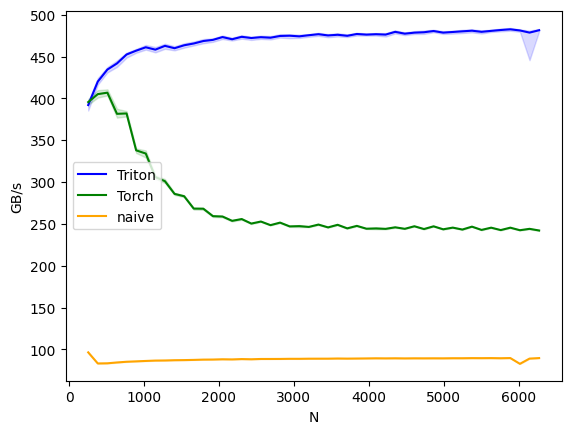

t_log_softmax_fwd:
         N      Triton       Torch      naive
0    256.0  392.039898  395.589537  96.376474
1    384.0  420.102570  405.098894  83.103066
2    512.0  434.492807  406.845308  83.290831
3    640.0  441.815741  381.540824  84.297905
4    768.0  452.492510  382.010363  85.136257
5    896.0  457.076038  337.897369  85.622677
6   1024.0  461.115230  334.083263  86.104122
7   1152.0  458.293699  305.978210  86.539440
8   1280.0  462.824835  300.992043  86.672543
9   1408.0  459.999592  285.842987  86.991189
10  1536.0  463.515904  283.024947  87.129623
11  1664.0  465.641090  268.251892  87.357441
12  1792.0  468.592439  268.119218  87.693132
13  1920.0  469.979279  259.217714  87.789721
14  2048.0  473.326523  258.779854  88.108227
15  2176.0  470.718389  253.620378  87.942324
16  2304.0  473.627404  255.759479  88.341091
17  2432.0  472.197170  250.355334  88.121350
18  2560.0  473.184092  252.790744  88.462542
19  2688.0  472.561307  248.466509  88.469179
20  2816.0  474

In [10]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[128 * i for i in range(2, 50)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_log_softmax_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [11]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=df82317b-d317-7368-eed6-8c8a4866f43b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [12]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
print(f'num_stages', num_stages, 'num_warps', num_warps)
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)

dloss_dx_2d = torch.randn_like(x_2d)
kernel = t_log_softmax_bkwd2_k.warmup(dloss_dx_2d, x_2d, output, dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                    num_stages=num_stages, num_warps=num_warps, grid=(1, ))
#kernel = t_log_softmax_fwd_k.warmup(x_2d, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
#                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 34 size_smem 4128
occupancy 7 24
num_programs 560


In [8]:
32
2080
4128
6176

6176